# Model Demo file

In this file, there is code to load and run the best models of the various architectures created by the team.

**This notebook contains the following sections:**

1. EfficientNetB5
2. DINOv2
3. Swin
4. EfficientNetB5 + SE + ASF (ENSE)
5. EfficientNetB5 + SE + ASF + DINOv2
6. EfficientNetB5 + SE + ASF + Swin (ENSESwin)

**Assumed project structure:**
```markdown
ROOT
├── notebooks                                       <-- folder with the notebooks
│   ├── modelDemo.ipynb                             <-- current notebook used for demonstrating models
│   └── ...                                      
│
├── models                                          <-- folder with the models
│   ├── DINOv2
│   │   └── DINOv2_best_model.pt                    
│   ├── ENSE
│   │   └── ENSE_best_model.pt                      
│   ├── ENSESwin
│   │   └── ENSESwin_best_model.pt                  
│   ├── FINAL_EfficientNetB5
│   │   └── FINAL_EfficientNetB5_best_model.pt      
│   ├── FINAL_EfficientNetDINOv2
│   │   └── FINAL_EfficientNetDINOv2_best_model.pt  
│   └── FINAL_Swin
│      └── FINAL_Swin_best_model.pt    
│            
└── input                                           <-- folder with the dataset
    └── final_split_15Apr2025                       <-- preprocessed dataset from drive
        ├── train
        ├── eval
        └── test
```

Configurable Variables:
- **root (str)**: Root directory of the project (commonly set to '..').
- **data_set_directory (str)**: Name of the directory containing all datasets (i.e.,'input')
- **root_result_folder (str)**: Top-level directory name for storing evaluation results.
- **model_directory (str)**: Directory name where all trained models will be saved.
- **final_data_set (str)**: Folder name of the final processed and augmented dataset used for training.

- **images_to_print (str)**: The number of images to be explictly printed with labels


In [1]:
# Control Panel to adjust variables
root = ".."
data_set_directory = "input"
root_result_folder = "results"
model_directory = "models" 
final_data_set = "final_split_15Apr2025"

images_to_print= 3
batch_size = 64 # State the number of datapoints in each batch size

## Setup

In [2]:
from typing import List, Optional, Callable
import os
import sys
from tqdm.auto import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import numpy as np

import timm
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
import random
import torchvision.transforms.functional as F
from timm.models.swin_transformer import SwinTransformer


# Determine the project root - required to import DataHandler from utils folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), root))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.DataHandler import download_dataset, create_full_data_loaders
from utils.helperFunctions import unnormalize

c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RESULTS_DIR = os.path.join(PROJECT_ROOT, root_result_folder)
os.makedirs(RESULTS_DIR, exist_ok=True)

DATASET_FOLDER = os.path.join(root, data_set_directory,final_data_set)

MODELS_BASE_DIR = os.path.join(root, model_directory)

ROOT_DATA_DIR = os.path.join(root, data_set_directory)

# Gets the device to be used
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

DEVICE = get_device()

Using device: CUDA (GPU)


In [4]:
# Function to download the processed dataset used by the team
download_dataset(final_data_set,f"https://drive.google.com/uc?id=1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg",  F"{DATASET_FOLDER}.zip", ROOT_DATA_DIR)

Dataset already exists at final_split_15Apr2025


### Loading Dataset

In [5]:
SPLIT_DATASET = os.path.abspath(DATASET_FOLDER)
BATCH_SIZE = batch_size

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

print("LOADING FULL DATASET-------------------------------------------------------")
# Creating dataloader to load the full dataset for training the actual models and testing
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

LOADING FULL DATASET-------------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572


## Models

### EfficientNetB5 (Done)

#### Model Download

#### Model Specification

In [16]:
class BaseEfficientNetB5(nn.Module):
    """EfficientNetB5 model for transfer learning on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified

    This model uses a pretrained EfficientNetB5 backbone and replaces its
    classifier with a multi-layer fully connected network whose architecture
    can be tuned (number of layers, neurons, and activation function)
    """
    
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(BaseEfficientNetB5, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        in_features = self.backbone.classifier[1].in_features
        
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False
        
        # Build the classifier based on the provided hidden_sizes
        layers = []
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.backbone.classifier[1] = nn.Sequential(*layers)
    
    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

#### Testing Code

Test Loss: 0.6131, Test Accuracy: 77.62%

Classification Report:
               precision    recall  f1-score   support

       angry       0.89      0.75      0.81       140
       happy       0.77      0.80      0.79       148
     relaxed       0.65      0.75      0.70       146
         sad       0.85      0.80      0.82       138

    accuracy                           0.78       572
   macro avg       0.79      0.78      0.78       572
weighted avg       0.79      0.78      0.78       572


 F1 score: 0.7796850642569092; 
 Precision score: 0.7886534660191976; 
 Recall Score: 0.7761450402159157


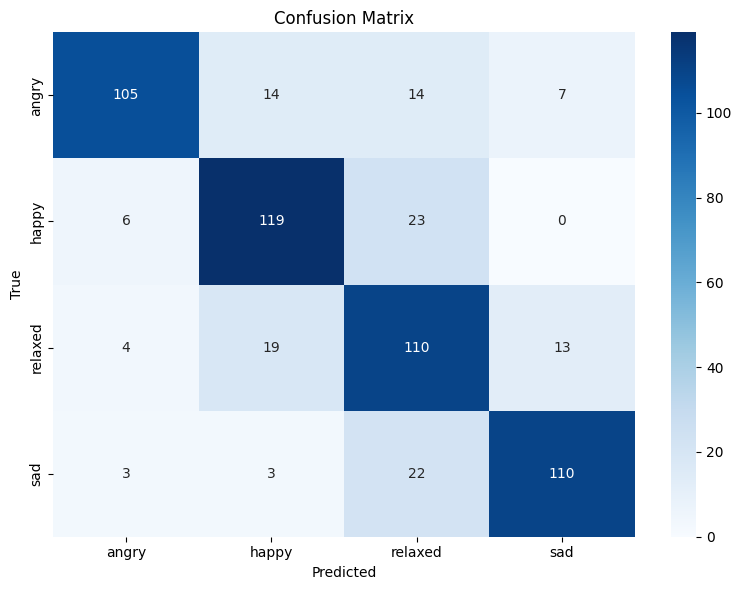

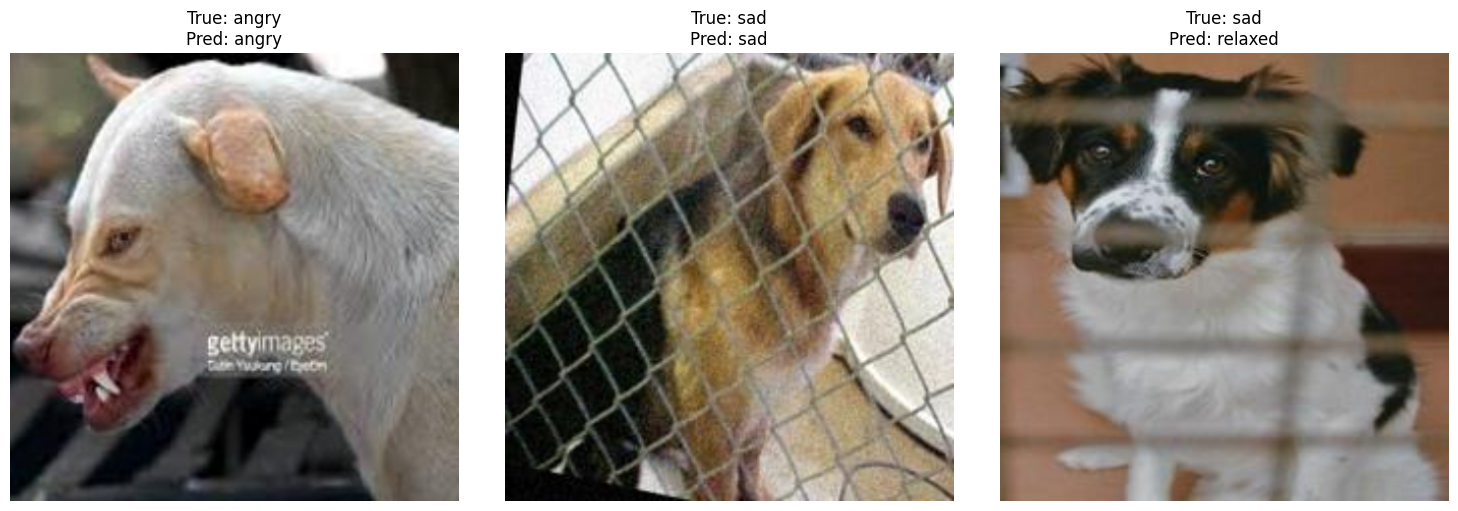

In [18]:
# Config From hyperparameter tuning leading to the best model
best_config = {
    'lr': 0.0007591104805282694,
    'weight_decay': 1.7541893487450798e-05,
    'dropout': 0.399035382022254,
    'hidden_sizes': [512, 256],
    'activation': 'relu',
    'freeze_backbone': True,
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    'criterion': lambda: nn.CrossEntropyLoss()
}

final_model = BaseEfficientNetB5(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)
# load best model from training
modelName = "FINAL_EfficientNetB5"
final_model.load_state_dict(torch.load(os.path.join(MODELS_BASE_DIR, modelName, f"{modelName}_best_model.pt")))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, modelName , "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)

# Get random indices
random_indices = random.sample(range(len(FULL_TEST_LOADER.dataset)), images_to_print)

fig, axes = plt.subplots(1, images_to_print, figsize=(15, 5))
final_model.eval()

for i, idx in enumerate(random_indices):
    image, label = FULL_TEST_LOADER.dataset[idx]
    image_input = image.unsqueeze(0).to(DEVICE)
    output = final_model(image_input)
    _, predicted_label = torch.max(output, 1)

    # Unnormalize image
    unnorm_image = unnormalize(image.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_pil = F.to_pil_image(unnorm_image)

    # Plot within the correct subplot
    axes[i].imshow(img_pil)
    axes[i].axis("off")
    axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[predicted_label.item()]}")

plt.tight_layout()
plt.show()

### DINOv2 (error)

#### Model Specification

In [20]:
class BaseDINOv2(nn.Module):
    """DINOv2 model for transfer learning on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified

    This model uses a pretrained DINOv2 backbone and replaces its
    classifier with a multi-layer fully connected network whose architecture
    can be tuned (number of layers, neurons, and activation function)
    """
    
    def __init__(self,
                 model_variant: str = 'dinov2_vits14',
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            model_variant(str): the version of DINOv2 to load.
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(BaseDINOv2, self).__init__()

        # load DINOv2 backbone from Torch Hub
        self.backbone = torch.hub.load('facebookresearch/dinov2', model_variant)
        in_features = self.backbone.embed_dim  # e.g., 768 for vitb14, 384 for vits14
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Build the classifier based on the provided hidden_sizes
        layers = []
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.classifier = nn.Sequential(*layers)
    
    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.backbone(x)
        return self.classifier(features)

#### Testing

In [23]:
# Config From hyperparameter tuning leading to the best model
best_config = {
    'lr': 0.0007591104805282694,
    'weight_decay': 1.7541893487450798e-05,
    'dropout': 0.399035382022254,
    'hidden_sizes': [512, 256],
    'activation': 'relu',
    'freeze_backbone': True,
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    'criterion': lambda: nn.CrossEntropyLoss()
}

final_model = BaseDINOv2(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)
# load best model from training
modelName = "DINOv2"
final_model.load_state_dict(torch.load(os.path.join(MODELS_BASE_DIR, modelName, f"{modelName}_best_model.pt")))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, modelName , "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)

# Get random indices
random_indices = random.sample(range(len(FULL_TEST_LOADER.dataset)), images_to_print)

fig, axes = plt.subplots(1, images_to_print, figsize=(15, 5))
final_model.eval()

for i, idx in enumerate(random_indices):
    image, label = FULL_TEST_LOADER.dataset[idx]
    image_input = image.unsqueeze(0).to(DEVICE)
    output = final_model(image_input)
    _, predicted_label = torch.max(output, 1)

    # Unnormalize image
    unnorm_image = unnormalize(image.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_pil = F.to_pil_image(unnorm_image)

    # Plot within the correct subplot
    axes[i].imshow(img_pil)
    axes[i].axis("off")
    axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[predicted_label.item()]}")

plt.tight_layout()
plt.show()

Using cache found in C:\Users\yongl/.cache\torch\hub\facebookresearch_dinov2_main


AssertionError: Input image height 456 is not a multiple of patch height 14

### Swin (model was trained on 224 but currently we use 456)

#### Model Specification

In [32]:
class BaseSwin(nn.Module):
    """Swin model for transfer learning on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified

    This model uses a pretrained Swin backbone and replaces its
    classifier with a multi-layer fully connected network whose architecture
    can be tuned (number of layers, neurons, and activation function)
    """
    
    def __init__(self,
                 model_variant: str = 'swin_base_patch4_window7_224',
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            model_variant(str): the version of Swin to load.
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(BaseSwin, self).__init__()

        # load Swin backbone from timm
        self.backbone = timm.create_model(
            model_variant,
            pretrained=True,
            num_classes=0,     # disable head
            global_pool='avg'
        )
        
        in_features = self.backbone.num_features
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Build the classifier based on the provided hidden_sizes
        layers = []
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer.
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.classifier = nn.Sequential(*layers)
    
    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.backbone(x)
        return self.classifier(features)

#### Testing

In [33]:
# Config From hyperparameter tuning leading to the best model
best_config = {
    'lr': 0.0008118831797409269,
    'weight_decay': 3.43946938769063e-05,
    'dropout': 0.22260930176319738,
    'hidden_sizes': [128],
    'activation': 'relu',
    'freeze_backbone': True, 
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    'criterion': lambda: nn.CrossEntropyLoss()
}

final_model = BaseSwin(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)
# load best model from training
modelName = "FINAL_Swin"
final_model.load_state_dict(torch.load(os.path.join(MODELS_BASE_DIR, modelName, f"{modelName}_best_model.pt")))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, modelName , "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)

# Get random indices
random_indices = random.sample(range(len(FULL_TEST_LOADER.dataset)), images_to_print)

fig, axes = plt.subplots(1, images_to_print, figsize=(15, 5))
final_model.eval()

for i, idx in enumerate(random_indices):
    image, label = FULL_TEST_LOADER.dataset[idx]
    image_input = image.unsqueeze(0).to(DEVICE)
    output = final_model(image_input)
    _, predicted_label = torch.max(output, 1)

    # Unnormalize image
    unnorm_image = unnormalize(image.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_pil = F.to_pil_image(unnorm_image)

    # Plot within the correct subplot
    axes[i].imshow(img_pil)
    axes[i].axis("off")
    axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[predicted_label.item()]}")

plt.tight_layout()
plt.show()

AssertionError: Input height (456) doesn't match model (224).

### EfficientNetB5 + SE + ASF (ENSE) (Done)

#### Model Specification

In [28]:
class SqueezeExcitationBlock(nn.Module):
    """
    Squeeze-and-Excitation (SE) block for channel-wise feature recalibration.

    This block implements the SE mechanism which adaptively recalibrates 
    channel-wise feature responses by explicitly modeling interdependencies 
    between channels.

    Args:
        channels (int): Number of input and output channels.
        reduction_ratio (int): Reduction ratio for the intermediate hidden layer. 
            Controls the bottleneck in the SE block (default: 16).

    Forward Input:
        x (Tensor): Input feature map of shape (batch_size, channels, height, width).

    Forward Output:
        Tensor: Output feature map of the same shape, with recalibrated channel responses.
    """

    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class AttentionalSelectiveFusion(nn.Module):
    """
    Attentional Selective Fusion (ASF) Block for Channel-wise Feature Recalibration.

    This module enhances the representational capacity of convolutional neural networks
    by applying a lightweight channel attention mechanism. It uses global average pooling
    followed by a bottleneck transformation and sigmoid activation to compute 
    per-channel attention weights. The input tensor is then modulated by these weights,
    selectively emphasizing informative features.

    Args:
        in_channels (int): Number of input and output channels in the input feature map.

    Forward Input:
        x (torch.Tensor): Feature map of shape (batch_size, in_channels, height, width)

    Forward Output:
        torch.Tensor: Recalibrated feature map of the same shape as input"""
    def __init__(self, in_channels: int):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels // 16, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(self.avg(x))
        return x * w
    
class SEEfficientNetB5(nn.Module):
    """
    EfficientNetB5-based classifier with optional Squeeze-and-Excitation (SE) block, 
    customizable classifier head, and partial layer unfreezing for fine-tuning.

    Designed for flexibility during hyperparameter tuning (e.g., with Ray Tune).

    Args:
        num_classes (int): Number of output classes. Default is 4.
        dropout (float): Dropout probability used in the classifier head. Default is 0.2.
        hidden_sizes (Optional[List[int]]): List of hidden layer sizes for the classifier head. 
            If None, no additional hidden layers are added beyond the SE block (if used).
        activation (str): Activation function to use in the classifier head. 
            Supported values: 'relu', 'tanh', 'sigmoid'. Default is 'relu'.
        use_se (bool): Whether to include a Squeeze-and-Excitation (SE) block before the classifier. Default is True.
        unfreeze_blocks (Optional[List[int]]): List of block indices in EfficientNetB5's features to unfreeze 
            for fine-tuning. If None, the entire backbone remains frozen.

    Notes:
        - The SE block is applied to the flattened output of the backbone if `use_se` is True.
        - The classifier head is built dynamically based on `hidden_sizes` and activation.
        - The EfficientNetB5 backbone is loaded with pretrained weights by default.
    """
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 use_se: bool = True,
                 unfreeze_blocks: Optional[List[int]] = None) -> None:
        """
        Initializes an instance of the model with the specified configuration.

        Args:
            num_classes (int, optional): The number of output classes for the model. Default is 4.
            dropout (float, optional): The dropout rate to be applied to the model. Default is 0.2.
            hidden_sizes (List[int], optional): A list specifying the sizes of hidden layers in the model.
                                                If None, the model will use a default configuration. Default is None.
            activation (str, optional): The activation function to use in the model. Default is 'relu'.
                                        Other possible values might include 'sigmoid', 'tanh', etc.
            use_se (bool, optional): Whether or not to use the Squeeze-and-Excitation (SE) block in the model. 
                                        Default is True.
            unfreeze_blocks (List[int], optional): A list of blocks to be unfrozen during training.
                                                    Default is None, which means no blocks are unfrozen.

        """
        super(SEEfficientNetB5, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        in_features = self.backbone.classifier[1].in_features

        # Setting the values layers in the efficientnet backbone that will be frozen
        for param in self.backbone.features.parameters():
            param.requires_grad = False

        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for param in self.backbone.features[idx].parameters():
                    param.requires_grad = True

        # Build the classifier head with the SE and additional layers according to the number of layers in the hidden state
        layers = []
        if use_se:
            layers.extend([
                nn.Unflatten(1, (in_features, 1, 1)),
                SqueezeExcitationBlock(in_features),
                AttentionalSelectiveFusion(in_features),
                nn.Flatten()
            ])
        
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
        
        layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(input_dim, num_classes))

        self.backbone.classifier[1] = nn.Sequential(*layers)

    def _get_activation(self, activation: str) -> Callable:
        """
        Returns the specified activation function from PyTorch's nn module.

        Args:
            activation (str): Name of the activation function. Supported values are
                'relu', 'tanh', and 'sigmoid' (case-insensitive).

        Returns:
            Callable: The corresponding activation function module (e.g., nn.ReLU()).

        Raises:
            ValueError: If an unsupported activation function name is provided.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

#### Testing

Test Loss: 0.3882, Test Accuracy: 87.94%

Classification Report:
               precision    recall  f1-score   support

       angry       0.92      0.87      0.89       140
       happy       0.91      0.93      0.92       148
     relaxed       0.84      0.86      0.85       146
         sad       0.85      0.86      0.85       138

    accuracy                           0.88       572
   macro avg       0.88      0.88      0.88       572
weighted avg       0.88      0.88      0.88       572


 F1 score: 0.8790246473485257; 
 Precision score: 0.8796758569571899; 
 Recall Score: 0.878774462797691


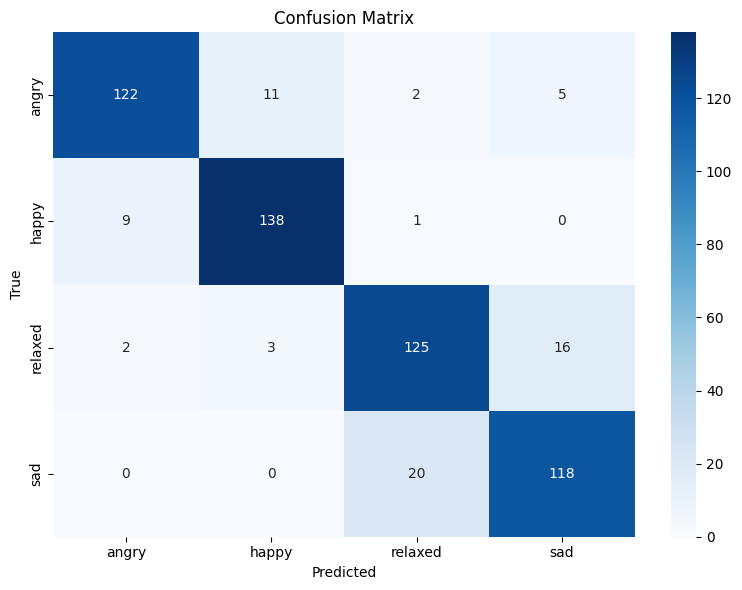

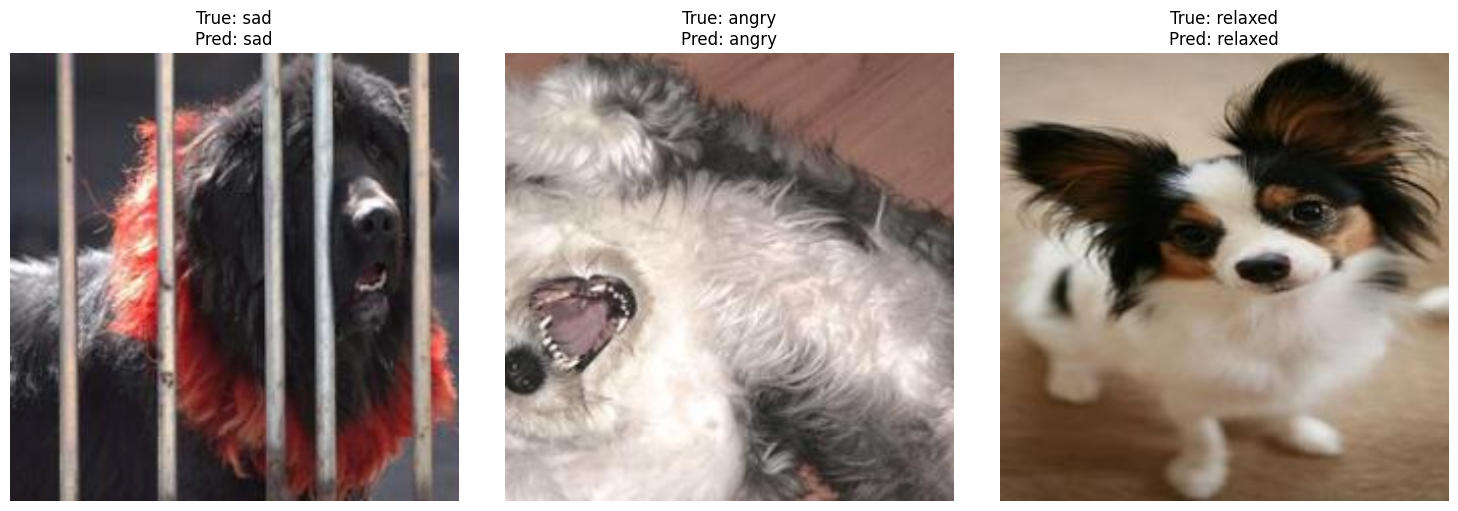

In [29]:
# Config From hyperparameter tuning leading to the best model
best_config = {
    'lr': 3.667553423789653e-05,
    'weight_decay': 1.8610170848142728e-05,
    'dropout': 0.39636006949943725,
    'hidden_sizes': None, 
    'activation': 'tanh', 
    'unfreeze_blocks': [6, 7], 
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    'criterion': lambda: nn.CrossEntropyLoss()
}

final_model = SEEfficientNetB5(
    num_classes=4,
    dropout=best_config["dropout"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"],
    unfreeze_blocks=best_config["unfreeze_blocks"]
)
# load best model from training
modelName = "ENSE"
final_model.load_state_dict(torch.load(os.path.join(MODELS_BASE_DIR, modelName, f"{modelName}_best_model.pt")))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, modelName , "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)

# Get random indices
random_indices = random.sample(range(len(FULL_TEST_LOADER.dataset)), images_to_print)

fig, axes = plt.subplots(1, images_to_print, figsize=(15, 5))
final_model.eval()

for i, idx in enumerate(random_indices):
    image, label = FULL_TEST_LOADER.dataset[idx]
    image_input = image.unsqueeze(0).to(DEVICE)
    output = final_model(image_input)
    _, predicted_label = torch.max(output, 1)

    # Unnormalize image
    unnorm_image = unnormalize(image.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_pil = F.to_pil_image(unnorm_image)

    # Plot within the correct subplot
    axes[i].imshow(img_pil)
    axes[i].axis("off")
    axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[predicted_label.item()]}")

plt.tight_layout()
plt.show()

### EfficientNetB5 + SE + ASF+ DINOv2 (Done)

#### Model Specifcation

In [30]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class AttentionalSelectiveFusion(nn.Module):
    """Simple channel‑attention fusion block"""
    def __init__(self, in_channels: int):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels // 16, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(self.avg(x))
        return x * w

class EfficientNetDINOv2(nn.Module):
    """Modified EfficientNetB5 with Squeeze and Extraction Blocks for feature extraction;
    then DINOv2 model on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified
    """
    
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(EfficientNetDINOv2, self).__init__()


        # load EfficientNet‑B5 backbone
        self.backbone = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT).features  # [B, 2048, 7, 7] for 224×224

        # freeze backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            for name, param in self.backbone.named_parameters():
                if "6" in name or "7" in name:
                    param.requires_grad = True #freeze for now cause comp cmi

        # SE block
        self.se = SqueezeExcitationBlock(2048)

        # Attentional Selective Fusion & projection to match DINOv2 model
        self.asf   = AttentionalSelectiveFusion(2048)
        self.proj  = nn.Conv2d(2048, 384, kernel_size=1)

        # force map to 37×37 so token count matches DINOv2‑ViT‑S/14 (1370 = 1+37²)
        self.adapt = nn.AdaptiveAvgPool2d((37, 37))

        # DINOv2 (ViT‑S/14) without patch embed
        self.dino  = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
        # freeze too
        if freeze_backbone:
            for param in self.dino.parameters():
                param.requires_grad = False

        # build classifier
        layers = []
        input_dim = self.dino.embed_dim  #should be 384
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.classifier = nn.Sequential(*layers)

    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # EfficientNet feature map
        x = self.backbone(x)          # [B, 2048, 7, 7]
        x = self.se(x)
        x = self.asf(x)               # attentional fusion
        x = self.proj(x)              # [B, 384, 7, 7]
        x = self.adapt(x)             # [B, 384, 37, 37]

        # transformer expects image to the patch embedding layer, need to bypass
        # prepare tokens for DINOv2 transformer
        B, C, H, W = x.shape
        tokens = x.flatten(2).transpose(1, 2)   # [B, 1369, 384]

        # prepend cls token + add positional embedding
        cls_tok  = self.dino.cls_token.expand(B, -1, -1)  # [B,1,384]
        tokens   = torch.cat((cls_tok, tokens), dim=1)     # [B,1370,384]
        tokens   = tokens + self.dino.pos_embed            # match length 1370

        # transformer encoder
        for blk in self.dino.blocks:
            tokens = blk(tokens)
        tokens = self.dino.norm(tokens)

        # take CLS representation
        rep = tokens[:, 0]            # [B, 384]
        return self.classifier(rep)

#### Testing

Using cache found in C:\Users\yongl/.cache\torch\hub\facebookresearch_dinov2_main


Test Loss: 0.4274, Test Accuracy: 86.36%

Classification Report:
               precision    recall  f1-score   support

       angry       0.90      0.86      0.88       140
       happy       0.93      0.86      0.90       148
     relaxed       0.78      0.87      0.82       146
         sad       0.86      0.86      0.86       138

    accuracy                           0.86       572
   macro avg       0.87      0.86      0.86       572
weighted avg       0.87      0.86      0.86       572


 F1 score: 0.8646084761772039; 
 Precision score: 0.8677644596367448; 
 Recall Score: 0.8635215141543313


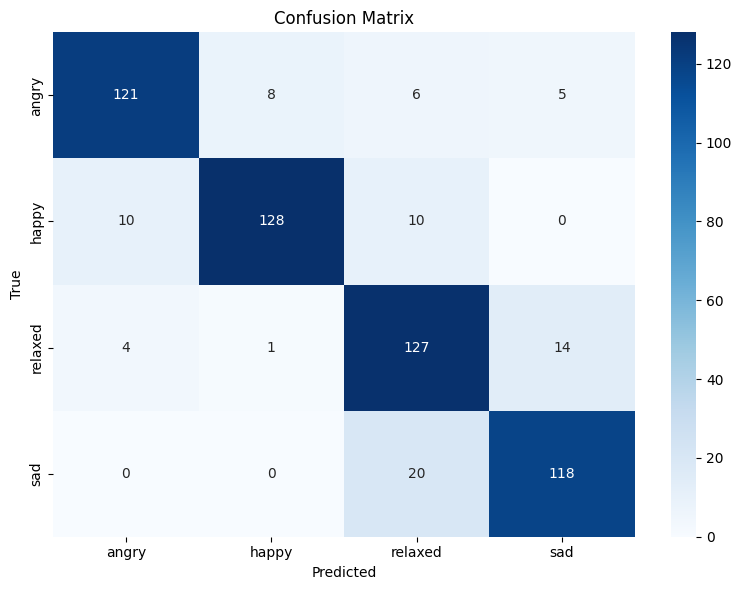

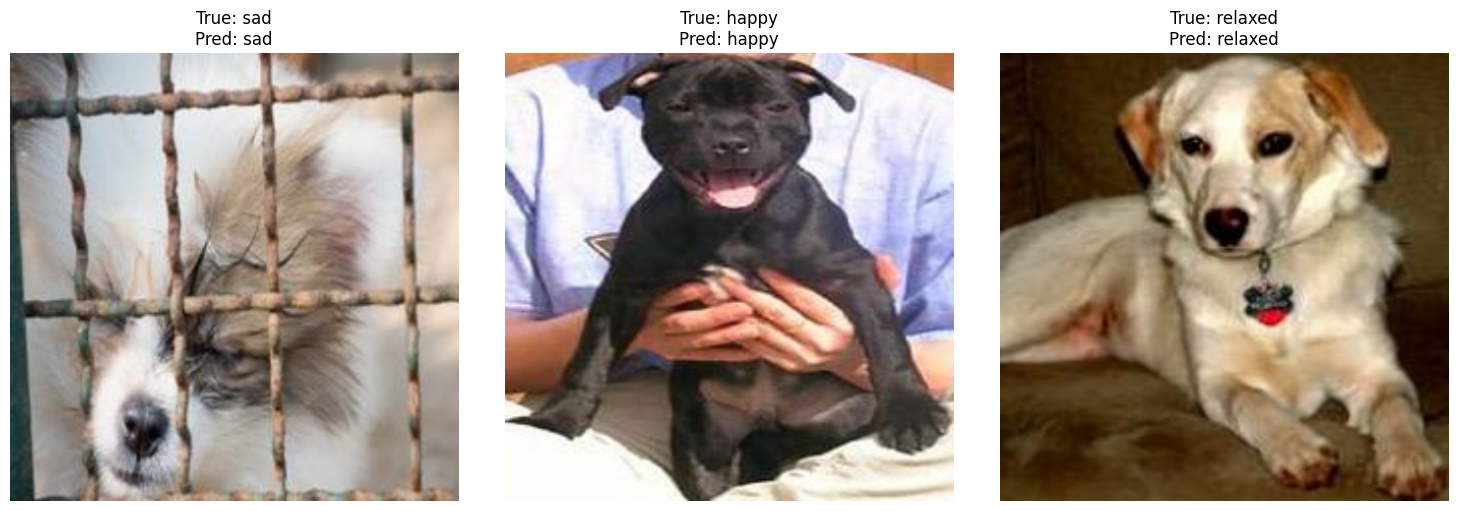

In [31]:
# Config From hyperparameter tuning leading to the best model
best_config = {
    'lr':  5.6115164153345e-05,
    'weight_decay': 0.0007969454818643932,
    'dropout': 0.446398788362281,
    'hidden_sizes': None,
    'activation': 'relu',
    'label_smooth': '0.05',
    'freeze_backbone': True,
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.AdamW(params, lr=lr, weight_decay=wd),
    'criterion': lambda ls: nn.CrossEntropyLoss(label_smoothing=ls),
}

final_model = EfficientNetDINOv2(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)
# load best model from training
modelName = "FINAL_EfficientNetDINOv2"
final_model.load_state_dict(torch.load(os.path.join(MODELS_BASE_DIR, modelName, f"{modelName}_best_model.pt")))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, modelName , "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)

# Get random indices
random_indices = random.sample(range(len(FULL_TEST_LOADER.dataset)), images_to_print)

fig, axes = plt.subplots(1, images_to_print, figsize=(15, 5))
final_model.eval()

for i, idx in enumerate(random_indices):
    image, label = FULL_TEST_LOADER.dataset[idx]
    image_input = image.unsqueeze(0).to(DEVICE)
    output = final_model(image_input)
    _, predicted_label = torch.max(output, 1)

    # Unnormalize image
    unnorm_image = unnormalize(image.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_pil = F.to_pil_image(unnorm_image)

    # Plot within the correct subplot
    axes[i].imshow(img_pil)
    axes[i].axis("off")
    axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[predicted_label.item()]}")

plt.tight_layout()
plt.show()

### EfficientNetB5 + SE + ASF + Swin Transformer (ENSESwin) (Done)

#### Model Specifcation

In [12]:
class SqueezeExcitationBlock(nn.Module):
    """
    Squeeze-and-Excitation (SE) block for channel-wise feature recalibration.

    This block implements the SE mechanism which adaptively recalibrates 
    channel-wise feature responses by explicitly modeling interdependencies 
    between channels.

    Args:
        channels (int): Number of input and output channels.
        reduction_ratio (int): Reduction ratio for the intermediate hidden layer. 
            Controls the bottleneck in the SE block (default: 16).

    Forward Input:
        x (Tensor): Input feature map of shape (batch_size, channels, height, width).

    Forward Output:
        Tensor: Output feature map of the same shape, with recalibrated channel responses.
    """

    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class AttentionalSelectiveFusion(nn.Module):
    """
    Attentional Selective Fusion (ASF) Block for Channel-wise Feature Recalibration.

    This module enhances the representational capacity of convolutional neural networks
    by applying a lightweight channel attention mechanism. It uses global average pooling
    followed by a bottleneck transformation and sigmoid activation to compute 
    per-channel attention weights. The input tensor is then modulated by these weights,
    selectively emphasizing informative features.

    Args:
        in_channels (int): Number of input and output channels in the input feature map.

    Forward Input:
        x (torch.Tensor): Feature map of shape (batch_size, in_channels, height, width)

    Forward Output:
        torch.Tensor: Recalibrated feature map of the same shape as input"""
    def __init__(self, in_channels: int):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels // 16, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(self.avg(x))
        return x * w
    

class SwinFicientNet(nn.Module):
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 unfreeze_blocks: Optional[List[int]] = None):
        super().__init__()
        """
        Initializes an instance of the model with the specified configuration.

        Args:
            num_classes (int, optional): The number of output classes for the model. Default is 4.
            dropout (float, optional): The dropout rate to be applied to the model. Default is 0.2.
            hidden_sizes (List[int], optional): A list specifying the sizes of hidden layers in the model.
                                                If None, the model will use a default configuration. Default is None.
            activation (str, optional): The activation function to use in the model. Default is 'relu'.
                                        Other possible values might include 'sigmoid', 'tanh', etc.
            unfreeze_blocks (List[int], optional): A list of blocks to be unfrozen during training.
                                                    Default is None, which means no blocks are unfrozen.

        """
        # 1) EfficientNet-B5 feature extractor only
        eff = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)
        self.backbone = eff.features  # <-- 4D conv maps
        feat_channels = 2048          # EfficientNetB5's final feature‐map channels

        # Freeze all EfficientNet layers, then optionally unfreeze some
        for p in self.backbone.parameters():
            p.requires_grad = False
        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for p in self.backbone[idx].parameters():
                    p.requires_grad = True

        # 2) Squeeze‐Excitation on the conv maps
        self.se = SqueezeExcitationBlock(feat_channels)
        self.asf   = AttentionalSelectiveFusion(2048)

        # 3) Project into 96 channels for Swin
        self.project    = nn.Conv2d(feat_channels, 96, kernel_size=1)
        self.adapt_pool = nn.AdaptiveAvgPool2d((14, 14))

        # 4) Swin Transformer head (classifier baked in)
        self.swin = SwinTransformer(
            img_size=14,
            patch_size=1,
            in_chans=96,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.1,
            ape=False,
            patch_norm=True,
            num_classes=num_classes
        )

        # 5) Optional extra MLP (if you want more hidden layers after Swin)
        layers = []
        if hidden_sizes:
            inp = num_classes
            for h in hidden_sizes:
                layers += [
                    nn.Dropout(dropout),
                    nn.Linear(inp, h),
                    self._get_activation(activation)
                ]
                inp = h
            layers += [nn.Dropout(dropout), nn.Linear(inp, num_classes)]
            self.post_swin = nn.Sequential(*layers)
        else:
            self.post_swin = nn.Identity()
    def _get_activation(self, act: str) -> nn.Module:
        """
        Returns the specified activation function from PyTorch's nn module.

        Args:
            activation (str): Name of the activation function. Supported values are
                'relu', 'tanh', and 'sigmoid' (case-insensitive).

        Returns:
            Callable: The corresponding activation function module (e.g., nn.ReLU()).

        Raises:
            ValueError: If an unsupported activation function name is provided.
        """
        act = act.lower()
        return {
            'relu'     : nn.ReLU(),
            'tanh'     : nn.Tanh(),
            'sigmoid'  : nn.Sigmoid(),
            'leakyrelu': nn.LeakyReLU()
        }[act]

    def forward(self, x):
        x = self.backbone(x)    # [B, 2048, H, W]
        x = self.se(x)          # SE block
        x = self.asf(x)         # attentional fusion
        x = self.project(x)     # [B,  96, H, W]
        x = self.adapt_pool(x)  # [B,  96, 14,14]
        x = self.swin(x)        # [B, num_classes]
        return self.post_swin(x)


#### Testing

Test Loss: 0.5779, Test Accuracy: 82.69%

Classification Report:
               precision    recall  f1-score   support

       angry       0.89      0.86      0.87       140
       happy       0.80      0.92      0.85       148
     relaxed       0.77      0.77      0.77       146
         sad       0.87      0.75      0.81       138

    accuracy                           0.83       572
   macro avg       0.83      0.83      0.83       572
weighted avg       0.83      0.83      0.83       572


 F1 score: 0.8263915006642758; 
 Precision score: 0.8312124489305456; 
 Recall Score: 0.8259143918018248


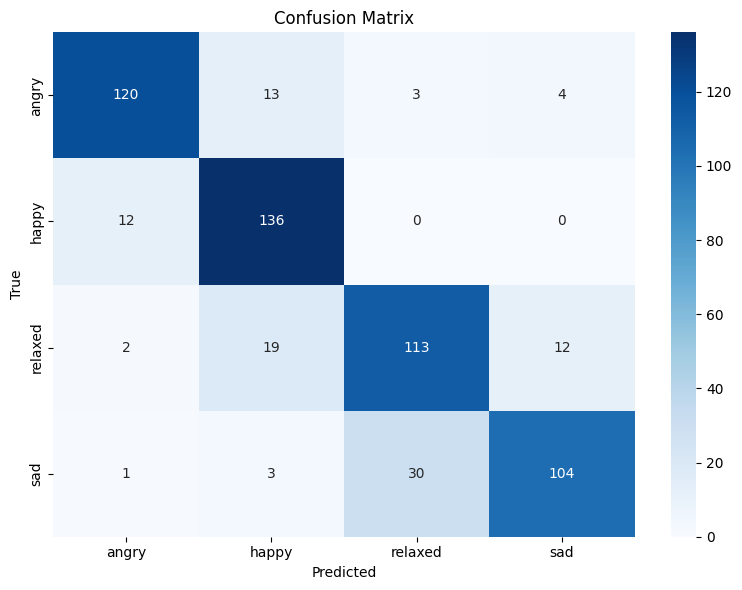

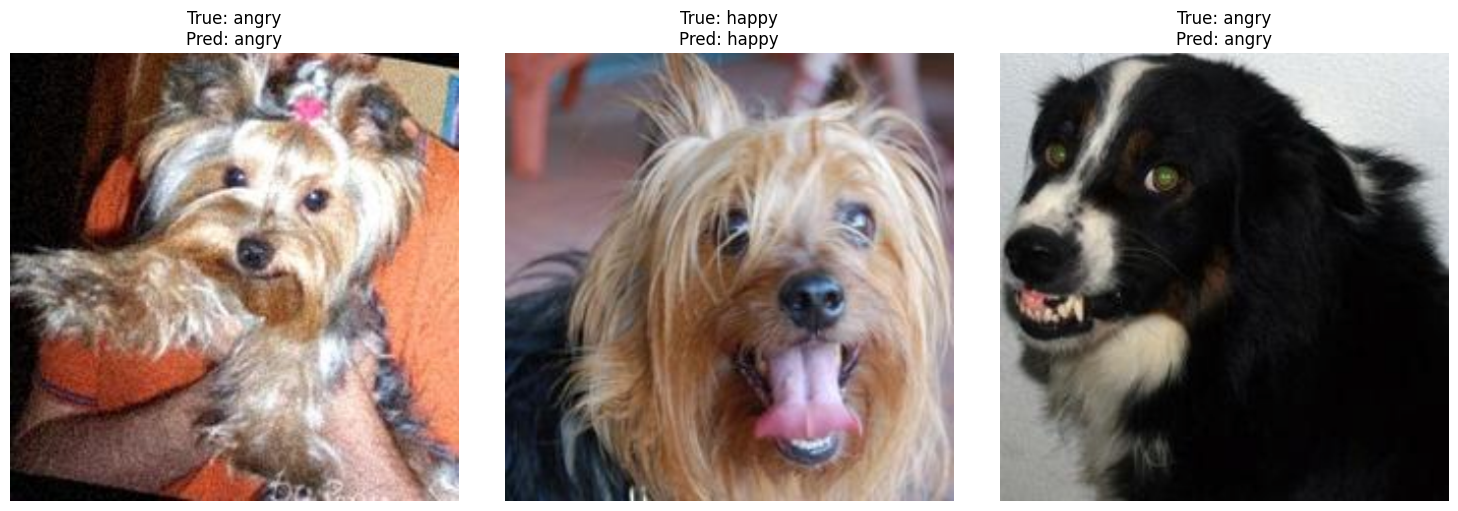

In [15]:
# Config From hyperparameter tuning leading to the best model
best_config = {
    'lr': 3.4655800089534934e-05,
    'weight_decay': 1.1476762138012849e-05,
    'dropout': 0.39011044234247205, 
    'hidden_sizes': [256, 128],
    'activation': 'relu', 
    'unfreeze_blocks': [6, 7],
    'num_epochs': 10,
    "optimiser": lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    "criterion": lambda: nn.CrossEntropyLoss()
}

final_model = SwinFicientNet(
    num_classes=4,
    dropout=best_config["dropout"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"],
    unfreeze_blocks=best_config["unfreeze_blocks"]
)
# load best model from training
modelName = "ENSESwin"
final_model.load_state_dict(torch.load(os.path.join(MODELS_BASE_DIR, modelName, f"{modelName}_best_model.pt")))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, modelName , "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)

# Get random indices
random_indices = random.sample(range(len(FULL_TEST_LOADER.dataset)), images_to_print)

fig, axes = plt.subplots(1, images_to_print, figsize=(15, 5))
final_model.eval()

for i, idx in enumerate(random_indices):
    image, label = FULL_TEST_LOADER.dataset[idx]
    image_input = image.unsqueeze(0).to(DEVICE)
    output = final_model(image_input)
    _, predicted_label = torch.max(output, 1)

    # Unnormalize image
    unnorm_image = unnormalize(image.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_pil = F.to_pil_image(unnorm_image)

    # Plot within the correct subplot
    axes[i].imshow(img_pil)
    axes[i].axis("off")
    axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[predicted_label.item()]}")

plt.tight_layout()
plt.show()